## Imports


In [1]:
import os
import matplotlib.pyplot as plt

import requests
import tarfile
import os

from tqdm import tqdm

import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import models
from torch import nn


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Definition of global constants

In [2]:
IMG_SIZE = (224,224)
IMAGE_PATH = os.path.join(os.getcwd(), 'dataset/images')

## Defining transformations

Defining transforms for images and labels. These are used for preprocessing each image used in the model

In [3]:
from torchvision import transforms
from torchvision.transforms import v2

from torchvision.models import ResNet34_Weights

# get transforms from resnet
weights = ResNet34_Weights.DEFAULT
resnet_preprocess = weights.transforms() # this is the preprocessing done by resnet34

# transforms used are those in https://pytorch.org/vision/stable/transforms.html example
train_transform = v2.Compose([
    # create random transform list
    v2.RandAugment()
])

val_transform = v2.Compose([
    v2.Resize(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Definition of training/testing loops

We now define the training/test functions as implemented in 
https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer, device, DEBUG=True, **kwargs):
    """
    Trains the model provided for one epoch.

    Returns:
        results : {
            'train_loss' : float, this is the average loss over the entire dataset,
            'train_accuracy' : float, this is the accuracy over the entire dataset
        }
    """
    print_every = int(kwargs.get('print_every', 10))
    data_aug = kwargs.get('data_aug', False)

    train_loss = 0
    train_accuracy = 0

    num_batches = len(dataloader)
    model.train()
    model.to(device)


    with tqdm(total=num_batches, dynamic_ncols=True) as pbar:
        for batch, (X, y) in enumerate(dataloader):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)

            #if data_aug:
            #    X = train_transform(X)

            pred = model(X)
            loss = loss_fn(pred, y)

            loss.backward()
            optimizer.step()

            # update loss and accuracy
            train_loss += loss.item()
            train_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

            if DEBUG and batch % print_every == 0:
                loss_item = loss.item()
                pbar.set_description(f"loss: {loss_item:>7f}  Batch:[{batch+1:>5d}/{num_batches:>5d}]")
            pbar.update(1)
    
    train_loss /= num_batches
    train_accuracy /= len(dataloader.dataset)
    return {
        'train_loss' : train_loss,
        'train_accuracy' : train_accuracy
    }

In [5]:
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.to(device)  # Move the model to the device
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # Move the data to the device
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return {'validation_loss': test_loss, 'validation_acc': correct}

In [6]:
def evaluate_model(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.to(device)  # Move the model to the device
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # Move the data to the device
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    accuracy = 100*correct
    return accuracy, test_loss

## We create a function that creates the datasets and loads the data

In [7]:
import random
from torch.utils.data import Subset
from torchvision.datasets import OxfordIIITPet

def load_data(**kwargs):
    transform = kwargs.get('transform', None)
    if transform is not None:
        training_transform = v2.Compose([
            resnet_preprocess,
            transform
        ])
    else:
        training_transform = resnet_preprocess
    training_data = OxfordIIITPet(root='dataset', split='trainval', target_types='category', transform=training_transform, download=True)
    validation_data = OxfordIIITPet(root='dataset', split='trainval', target_types='category', transform=resnet_preprocess, download=False)
    test_data = OxfordIIITPet(root='dataset', split='test', target_types='category', transform=resnet_preprocess, download=False)

    # shuffle and split into validation and training
    indices = list(range(len(training_data)))
    random.seed(310)  # fix the seed
    random.shuffle(indices)

    train_size = int(0.8 * len(training_data))
    train_dataset_split = Subset(training_data, indices[:train_size])
    val_dataset_split = Subset(validation_data, indices[train_size:])

    return train_dataset_split, val_dataset_split, test_data

## We define a function for creating models using different hyperparameters

In [8]:
num_classes = 37
def create_model(**kwargs):
    '''
    kwargs:
        include_layers : int, the number of layers to include in the model, 0 only includes the final layer, 1 includes the final layer and the last layer before it, etc.
        fine_tune_bn : bool, whether to fine tune the batch normalization layers
    '''
    include_layers = kwargs.get('include_layers', 0)
    fine_tune_bn = kwargs.get('fine_tune_bn', False)
    
    model = models.resnet34(weights='DEFAULT')

    layers_to_freeze = len(list(model.children())) - include_layers 

    # Freeze all layers that are not included
    for idx, layer in enumerate(model.children()):
        # Freeze batchnorm layers if fine_tune_bn is False
        if isinstance(layer, torch.nn.modules.batchnorm.BatchNorm2d) and not fine_tune_bn:
            for param in layer.parameters():
                param.requires_grad = False
        else:
            if idx < layers_to_freeze:
                for param in layer.parameters():
                    param.requires_grad = False

    # Change the output layer
    in_features = model.fc.in_features
    #model.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes, bias=True) 
    model.fc = torch.nn.Sequential(
            nn.Linear(in_features, 512),  # Add a dense layer
            nn.ReLU(),                 # Activation function
            nn.Dropout(0.4),           # Dropout layer for regularization
            nn.Linear(512, num_classes, bias=True) # Final output layer
        )
    return model

## Next we define the training function

In [9]:
def train_model(model, loss_fn, optimizer, train_dataloader, val_dataloader, **kwargs):
    """
    Args:
        **kwargs : {
            'epochs' : int,
            'device' : torch.device,
            'scheduler' : torch.scheduler,
            'data_aug' : bool
        }
    """
    epochs = kwargs.get('epochs', 5)
    device = kwargs.get('device', torch.device('cpu'))
    scheduler = kwargs.get('scheduler', None)

    training_results = []
    validation_results = []
    best_loss = 999
    counter = 0

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_res = train_loop(train_dataloader, model, loss_fn, optimizer, **kwargs)
        if scheduler is not None:
            scheduler.step()
        val_res = test_loop(val_dataloader, model, loss_fn, device)

        # append data
        training_results.append(train_res)
        validation_results.append(val_res)

        if val_res['validation_loss'] < best_loss:
            best_loss = val_res['validation_loss']
            counter = 0
        else:
            counter += 1
        # break if not improving for last 5 epochs
        if t > 5 and counter == 5:
            print("Early stopping!")
            break
    print("Training done!")

    return {'train_res': training_results, 'val_res': validation_results}

Lets try training a model

In [10]:
# make one graph for accuracy and one for loss
import seaborn as sns
# use style
sns.set_theme(style='whitegrid')

def create_graphs(results, filename):
    train_loss = [res['train_loss'] for res in results['train_res']]
    val_loss = [res['validation_loss'] for res in results['val_res']]

    train_acc = [res['train_accuracy'] for res in results['train_res']]

    val_acc = [res['validation_acc'] for res in results['val_res']]

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    sns.lineplot(x=range(1, len(train_loss)+1), y=train_loss, ax=ax[0], label='train_loss')
    sns.lineplot(x=range(1, len(val_loss)+1), y=val_loss, ax=ax[0], label='val_loss')

    sns.lineplot(x=range(1, len(train_acc)+1), y=train_acc, ax=ax[1], label='train_acc')
    sns.lineplot(x=range(1, len(val_acc)+1), y=val_acc, ax=ax[1], label='val_acc')

    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')

    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs')

    plt.savefig(filename)


We train the network using said parameters, running the test-loop on the validation set for each epoch to see if the model improves

In [17]:
import csv


# Define the hyperparameters and settings to test
include_layers_list = [1, 2, 3] #[-999, 1, 2]
learning_rates = [1e-3, 5e-3]
data_augmentation_enabled = [True, False]#", False]
#fine_tune_bn = [True, False]
fine_tune_bn = [True, False]
batch_size = 64
_epochs = 100

# Number of combinations of hyperparameters and settings
num_experiments = len(include_layers_list) * len(learning_rates) * len(data_augmentation_enabled) * len(fine_tune_bn)
print(f"Number of experiments: {num_experiments}")
"""
with open('experiment_results.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    model_name = f'Layers: {len(include_layers_list)}, LR: {len(learning_rates)}, Data Aug: {len(data_augmentation_enabled)}, Fine Tune BN: {len(fine_tune_bn)}'
    writer.writerow(["Include Layers", "Learning Rate", "Data Augmentation", "Fine Tune BN", "Test Accuracy", "Test Loss"])

    # Loop over all combinations of hyperparameters and settings
    for include_layers in include_layers_list:
        for lr in learning_rates:
            for data_aug in data_augmentation_enabled:
                for bn in fine_tune_bn:
                    # check if graph exists, if so, skip
                    graph_name = f'graphs/{include_layers}_{lr}_{data_aug}_{bn}.png'
                    if os.path.exists(graph_name):
                        print(f"Graph already exists for {include_layers}_{lr}_{data_aug}_{bn}.png, skipping...")
                        continue

                    print(f"Include Layers: {include_layers}, Learning Rate: {lr}, Data Augmentation: {data_aug}, Fine Tune BN: {bn}")

                    # Create the model and set up the layers to be fine-tuned
                    model = create_model(include_layers=include_layers, fine_tune_bn=bn)

                    # Set up the optimizer
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                    # Set up the data augmentation transformations if enabled
                    if data_aug:
                        train_transform = v2.RandAugment()
                    else:
                        train_transform = None

                    # Load the data
                    train_data, val_data, test_data = load_data(transform=train_transform)

                    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
                    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
                    test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=False, num_workers=4)
                    
                    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

                    # Train the model
                    results = train_model(model, nn.CrossEntropyLoss(), optimizer, train_dataloader, val_dataloader, epochs=_epochs, device=device, scheduler=scheduler, 
                                data_aug=data_aug)

                    # Evaluate the model on the validation set and get the accuracy
                    accuracy, test_loss = evaluate_model(test_dataloader, model, nn.CrossEntropyLoss(), device)

                    print(f"Test Accuracy: {accuracy:.2f}%") 

                    # Write the results to the CSV file
                    writer.writerow([include_layers, lr, data_aug, bn, accuracy, test_loss])

                    # generate graphs and save them
                    filename = f'graphs/{include_layers}_{lr}_{data_aug}_{bn}.png'
                    create_graphs(results, filename)
"""

Number of experiments: 24


'\nwith open(\'experiment_results.csv\', \'w\', newline=\'\') as file:\n    writer = csv.writer(file)\n    model_name = f\'Layers: {len(include_layers_list)}, LR: {len(learning_rates)}, Data Aug: {len(data_augmentation_enabled)}, Fine Tune BN: {len(fine_tune_bn)}\'\n    writer.writerow(["Include Layers", "Learning Rate", "Data Augmentation", "Fine Tune BN", "Test Accuracy", "Test Loss"])\n\n    # Loop over all combinations of hyperparameters and settings\n    for include_layers in include_layers_list:\n        for lr in learning_rates:\n            for data_aug in data_augmentation_enabled:\n                for bn in fine_tune_bn:\n                    # check if graph exists, if so, skip\n                    graph_name = f\'graphs/{include_layers}_{lr}_{data_aug}_{bn}.png\'\n                    if os.path.exists(graph_name):\n                        print(f"Graph already exists for {include_layers}_{lr}_{data_aug}_{bn}.png, skipping...")\n                        continue\n\n           

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

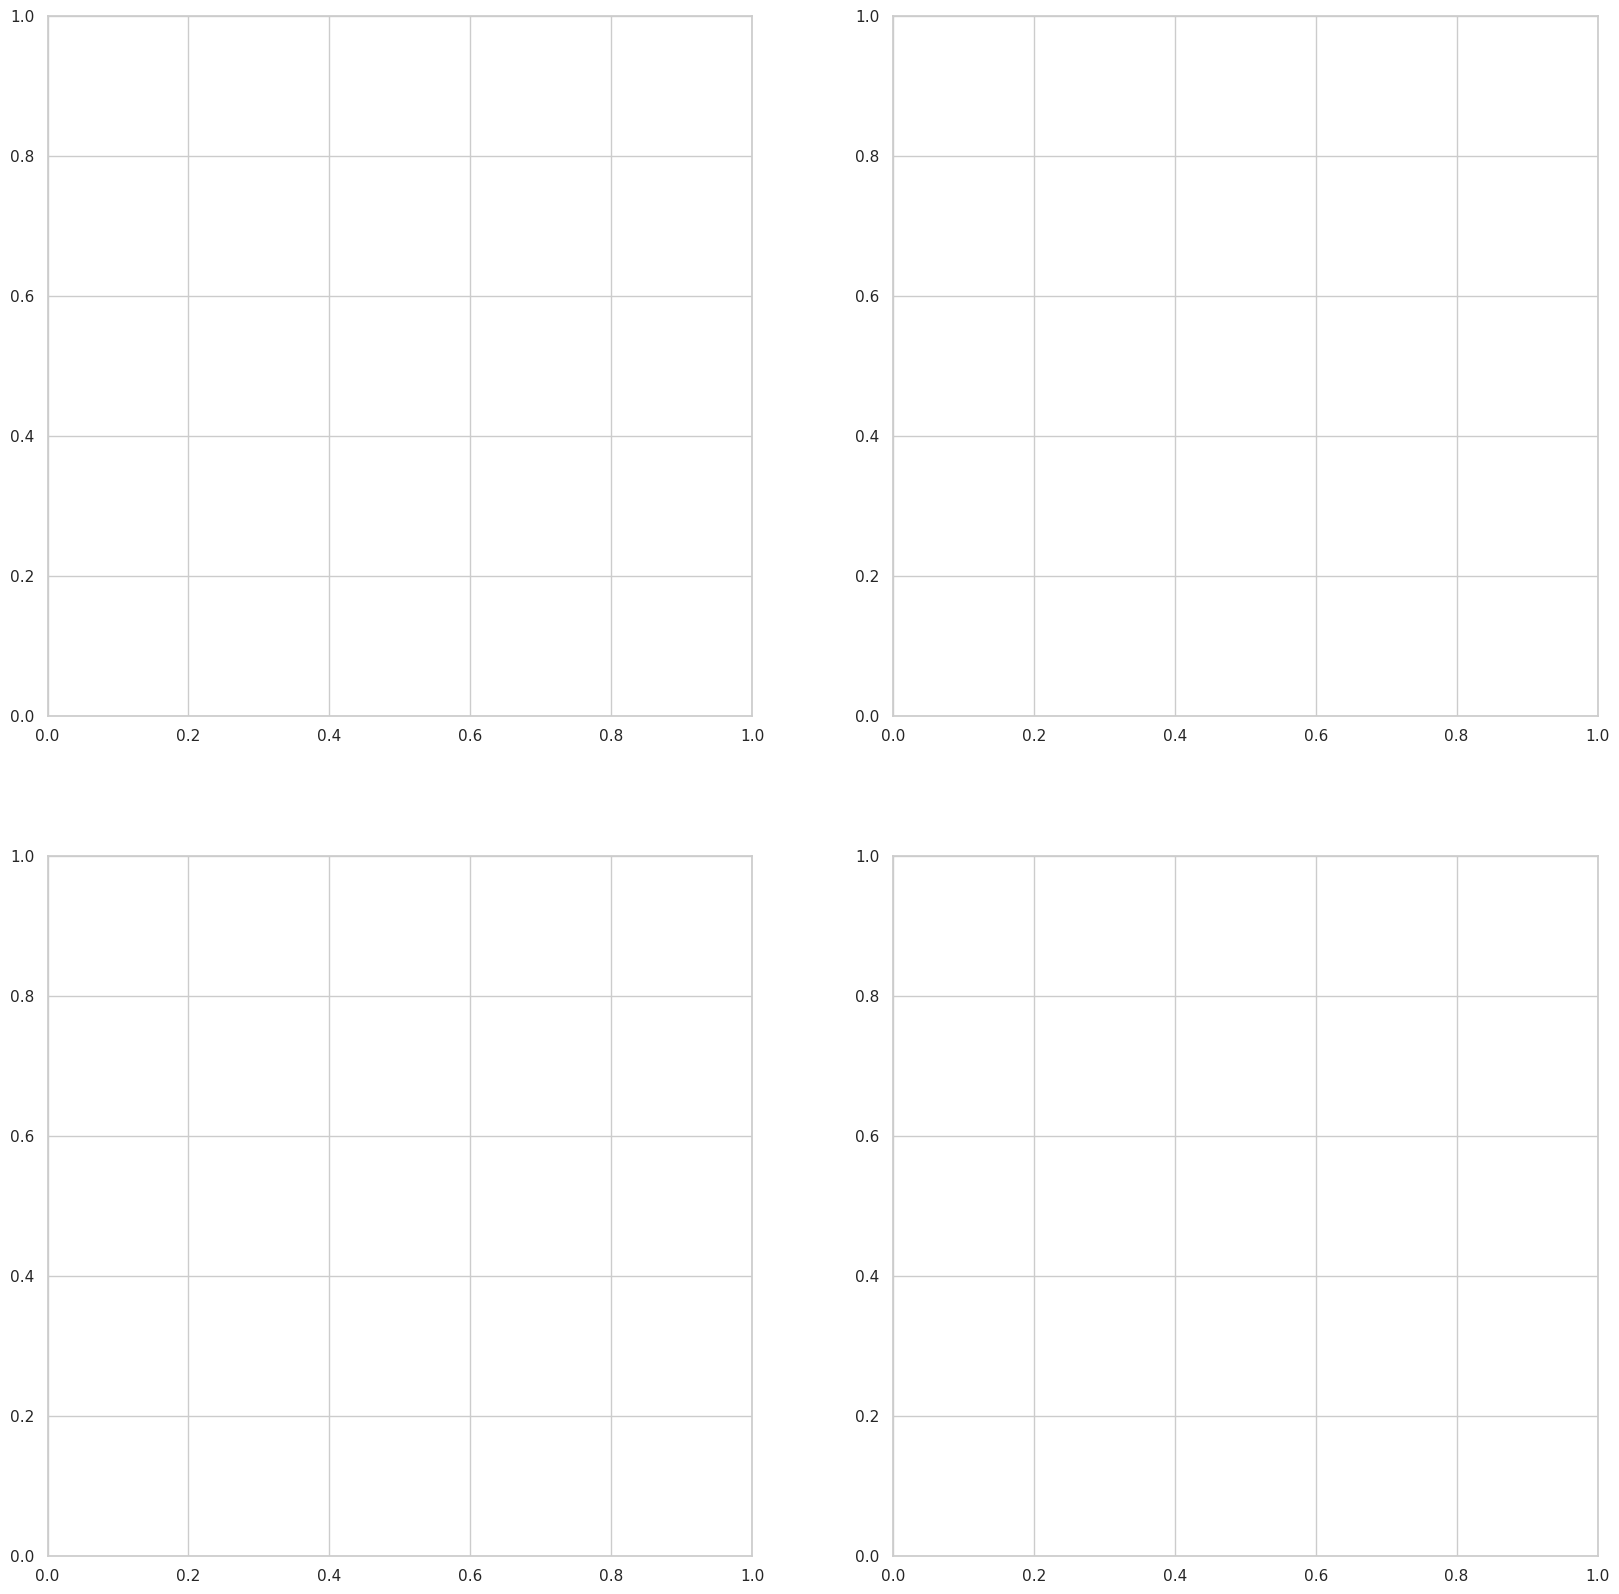

In [26]:
# now we want to visualize the graphs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# show all graphs for lowest learning rate
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

for idx, data_aug in enumerate(data_augmentation_enabled):
    for j, bn in enumerate(fine_tune_bn):
        filename = f'graphs/1_0.001_{data_aug}_{bn}.png'
        
        # load the image
        img = plt.imread(filename)
        ax[idx].imshow(img)
        ax[idx].axis('off')
        ax[idx].set_title(f'Data Aug: {data_aug}, Fine Tune BN: {bn}')



plt.show()
